Dependencies and dataset

In [1]:
import numpy as np
import pandas as pd # only for reading csv
import optuna # hyperparameter optimization
import matplotlib.pyplot as plt

import zipfile
import os
import logging
import sys

In [2]:
!kaggle datasets download -d oddrationale/mnist-in-csv -p ./data
with zipfile.ZipFile('./data/mnist-in-csv.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
os.remove('./data/mnist-in-csv.zip')


  0%|          | 0.00/15.2M [00:00<?, ?B/s]
  7%|▋         | 1.00M/15.2M [00:00<00:09, 1.53MB/s]
 13%|█▎        | 2.00M/15.2M [00:00<00:04, 3.06MB/s]
 33%|███▎      | 5.00M/15.2M [00:00<00:01, 8.20MB/s]
 59%|█████▉    | 9.00M/15.2M [00:01<00:00, 15.1MB/s]
 85%|████████▌ | 13.0M/15.2M [00:01<00:00, 20.9MB/s]
100%|██████████| 15.2M/15.2M [00:01<00:00, 13.5MB/s]


Define cost and activation functions

In [4]:
"""Activation functions and derivatives with respect to z"""
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))

def ReLu(z):
    return np.maximum(0,z)

def ReLu_derivative(z):
    return np.where(z > 0, 1.0, 0.001)

"""Cost functions and derivatives with respect to a"""
def cross_entropy(y,a):
    return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))

def cross_entropy_derivative(y,a):
    return np.nan_to_num((a-y) / (a*(1-a)))

def quadratic(y,a):
    return np.sum(0.5*(y-a)**2)

def quadratic_derivative(y,a):
    return a-y

activation_functions = {'sigmoid': (sigmoid, sigmoid_derivative), 'relu': (ReLu, ReLu_derivative)}
cost_functions = {'quadratic': (quadratic, quadratic_derivative), 'cross_entropy': (cross_entropy, cross_entropy_derivative)}

### Define Network class

In [5]:
class Network:
    def __init__(self, layers, cost_function = 'cross_entropy', activation_function = 'sigmoid'):
        self.L = layers
        self.W = [np.random.randn(x,y)/np.sqrt(y) for x,y in zip(self.L[1:],self.L[0:-1])] # Divide stadard deviation to avoid saturation
        self.B = [np.random.randn(x,1) for x in self.L[1:]]

        if cost_function in cost_functions:
            self.cost_function, self.cost_function_derivative = cost_functions[cost_function]
        else:
            raise ValueError(f"Invalid cost function: {cost_function}")
        if activation_function in activation_functions:
            self.activation_function, self.activation_derivative = activation_functions[activation_function]
        else:
            raise ValueError(f"Invalid activation function: {activation_function}")

    def feedforward(self, X):
        A = X
        for w, b in zip(self.W, self.B):
            Z = np.dot(w, A) + b
            A = self.activation_function(Z)
        return A

    def fit(self, train_set, batch_size, epochs, eta, lmbda, patience=10, valid_set=None, show_history=True, visualize=False):
        # Set-up
        X_train, Y_train = train_set
        if valid_set is not None:
            X_valid, Y_valid = valid_set
            print("Tracking progress on the validation set:")
        else:
            print("Tracking progress on the training set:")
        best_acc, best_cost, no_progress_count = 0.0, np.Inf, 0

        # Training
        accs = {'valid': [], 'train': []}
        costs = {'valid': [], 'train': []}
        for epoch in range(epochs):
            X_batches = np.array_split(X_train, X_train.shape[1] // batch_size, axis=1)
            Y_batches = np.array_split(Y_train, Y_train.shape[1] // batch_size, axis=1)
            for X_batch, Y_batch in zip(X_batches, Y_batches):  
                nabla_B = [np.zeros(b.shape) for b in self.B]
                nabla_W = [np.zeros(w.shape) for w in self.W]
                for i in range(X_batch.shape[1]):
                    a = X_batch[:,i].reshape(-1,1)
                    y = Y_batch[:,i].reshape(-1,1)
                    W_shifts, B_shifts = self.__get_shifts(a, y)
                    nabla_B = [nb+dnb for nb, dnb in zip(nabla_B, B_shifts)] 
                    nabla_W = [nw+dnw for nw, dnw in zip(nabla_W, W_shifts)]
                self.W = [w-eta*nw/X_batch.shape[1] - eta*lmbda*w/X_train.shape[1] for w, nw in zip(self.W, nabla_W)] # L2 regularization
                self.B = [b-eta*nb/X_batch.shape[1] for b, nb in zip(self.B, nabla_B)]

            # Tracking progress
            best_W, best_B = self.W.copy(), self.B.copy() # intialize best parameters as current ones
            if valid_set is not  None:
                acc, cost = self.__track_progress(X_valid, Y_valid)
                acc_train, cost_train = self.__track_progress(X_train, Y_train)
                accs['valid'].append(acc)
                costs['valid'].append(cost)
                accs['train'].append(acc_train)
                costs['train'].append(cost_train)  
            else:
                acc, cost = self.__track_progress(X_train, Y_train)
                accs['train'].append(acc)
                costs['train'].append(cost)

            if acc > best_acc or cost < best_cost:
                if acc > best_acc:
                    print('acc')
                    best_acc = acc
                    no_progress_count = 0
                    best_W, best_B = self.W.copy(), self.B.copy()  # update best parameters when accuracy improves
                if cost < best_cost:
                    print('cost')
                    best_cost = cost
                    no_progress_count = 0       
            else:
                no_progress_count += 1

            if no_progress_count > patience or eta<1e-6:
                self.W, self.B = best_W, best_B
                print(f"Early stopping: no improvement on validation set for {patience} epochs. Saving parameters from epoch {epoch-patience}.")
                #break
            elif show_history:
                if valid_set is not None:
                    print(f"epoch: {epoch}, ACC_val: {acc}, cost_val: {cost}, ACC_train: {acc_train}, cost_train: {cost_train}, no_progress_count: {no_progress_count}")
                else:    
                    print(f"epoch: {epoch}, ACC: {acc}, cost: {cost}")

        self.__track_progress(X_train, Y_train, visualize=visualize, accs=accs, costs=costs)

    def __track_progress(self, X, Y, visualize=False, accs={}, costs={}):
        """
        Evaluates accuracy and cost and the end of each epoch.
        """
        acc = self.evaluate(X, Y)[1]
        cost = round(self.cost_function(Y, self.feedforward(X))/X.shape[1], 4)

        if visualize:
            # Plotting after training
            plt.figure()
            plt.plot(range(len(costs['valid'])), costs['valid'], 'r-', label='Validation Cost')
            plt.plot(range(len(costs['train'])), costs['train'], 'b-', label='Training Cost')
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
            plt.yscale('log')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(range(len(accs['valid'])), accs['valid'], 'r-', label='Validation ACC')
            plt.plot(range(len(accs['train'])), accs['train'], 'b-', label='Training ACC')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
        return acc, cost

    def __get_shifts(self, a, y):
        """
        Updates network's weights and biases by applying backpropagation.
        """
        Z=[]
        A=[a]
        for w,b in zip(self.W,self.B):
            z = np.dot(w,A[-1])+b
            a=self.activation_function(z)
            Z.append(z)
            A.append(a)
        return self.__backprob(y, A, Z)

    def __backprob(self, y, A, Z):
        def delta(y,x,z):
            return self.cost_function_derivative(y,x)*self.activation_derivative(z)
            
        D = [delta(y,A[-1],Z[-1])] # eq. (1)
        for i in range(1,len(Z)):
            D.insert(0, np.dot(self.W[-i].T,D[0])*self.activation_derivative(Z[-i-1])) # eq. (2)
        B_shifts = D # eq. (3)
        W_shifts = []
        for a,d in zip(A[0:-1],D):
            W_shifts.append(np.dot(d,a.T)) # eq. (4)
        return W_shifts, B_shifts

    def evaluate(self, X, Y):
        correct_predictions = 0
        predictions = self.feedforward(X)
        for prediction, y in zip(predictions.T, Y.T):
            if np.argmax(prediction) == np.argmax(y):
                correct_predictions += 1
        return correct_predictions, correct_predictions/(X.shape[1])
    
    def save(self, path):
        np.savez(path, W=self.W)

Preprocess data

In [5]:
train = pd.read_csv('data\mnist_train.csv').to_numpy()
test = pd.read_csv('data\mnist_test.csv').to_numpy()

# Normalize data
X_train, Y_train = train[:,1:] / 255 , train[:,0]
X_test, Y_test = test[:,1:] / 255, test[:,0] 

# Shuffle training data
perm = np.random.permutation(len(X_train))
X_train = X_train[perm].T
Y_train = Y_train[perm]

# Divide to training, test and validation
X_valid = X_train[:,:10000]
X_train = X_train[:,10000:]
X_test=X_test.T

# Convert labels to one-hot encoded vectors
# Example: 2 -> (0,0,1,0,0,0,0,0,0,0) 
Y_valid = Y_train[:10000]
Y_train = Y_train[10000:]
Y_train = np.eye(10)[Y_train].T
Y_valid = np.eye(10)[Y_valid].T
Y_test = np.eye(10)[Y_test].T

In [6]:
training_data = pd.read_csv('data/mnist_train.csv').to_numpy()
test_data = pd.read_csv('data/mnist_test.csv').to_numpy()

def rotate_image(image, angle_range=(-10, 10)):
    def bilinear_interpolate(image, x, y):
      x0, x1 = int(np.floor(x)), int(np.ceil(x))
      y0, y1 = int(np.floor(y)), int(np.ceil(y))

      if x0 < 0 or x1 >= image.shape[0] or y0 < 0 or y1 >= image.shape[1]:
          return 0

      Ia = image[x0, y0]
      Ib = image[x0, y1]
      Ic = image[x1, y0]
      Id = image[x1, y1]

      wa = (x1 - x) * (y1 - y)
      wb = (x1 - x) * (y - y0)
      wc = (x - x0) * (y1 - y)
      wd = (x - x0) * (y - y0)

      return Ia * wa + Ib * wb + Ic * wc + Id * wd

    angle = np.random.uniform(angle_range[0], angle_range[1])
    angle_rad = np.deg2rad(angle)

    A = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    height, width = image.shape
    cx, cy = width // 2, height // 2

    rotated_image = np.zeros_like(image)

    for x in range(width):
        for y in range(height):
            (x_new, y_new) = np.dot([x - cx, y - cy], A) + (cx, cy)
            if 0 <= x_new < width and 0 <= y_new < height:
                rotated_image[x, y] = bilinear_interpolate(image, x_new, y_new)

    return rotated_image

def preprocess(training_data, test_data, augment_train=0):
    X_train, Y_train = training_data[:,1:] / 255 , training_data[:,0]
    X_test, Y_test = test_data[:,1:] / 255, test_data[:,0]

    perm = np.random.permutation(len(X_train))
    X_train = X_train[perm].T
    Y_train = Y_train[perm]

    X_valid = X_train[:,:10000]
    X_train = X_train[:,10000:]
    X_test=X_test.T


    Y_valid = Y_train[:10000]
    Y_train = Y_train[10000:]
    Y_train = np.eye(10)[Y_train].T
    Y_valid = np.eye(10)[Y_valid].T
    Y_test = np.eye(10)[Y_test].T

    for i in range(augment_train):
        original_image = X_train[:,i].reshape(28, 28)
        y=Y_train[:,i].reshape(-1,1)
        rotated_image = rotate_image(original_image).reshape(784, 1)
        X_train = np.concatenate((X_train, rotated_image), axis=1)
        Y_train = np.concatenate((Y_train, y), axis=1)

    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = preprocess(training_data, test_data, augment_train=10000)

Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9376, cost_val: 0.4127, ACC_train: 0.9410666666666667, cost_train: 0.4044, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9578, cost_val: 0.2889, ACC_train: 0.9618, cost_train: 0.2705, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9669, cost_val: 0.2345, ACC_train: 0.97165, cost_train: 0.2073, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9709, cost_val: 0.2047, ACC_train: 0.9779, cost_train: 0.1696, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9733, cost_val: 0.186, ACC_train: 0.9817833333333333, cost_train: 0.1437, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9746, cost_val: 0.1736, ACC_train: 0.9849166666666667, cost_train: 0.1244, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9764, cost_val: 0.1649, ACC_train: 0.9870666666666666, cost_train: 0.1093, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9777, cost_val: 0.1589, ACC_train: 0.989, cost_train: 0.0972, no_progress_count: 0


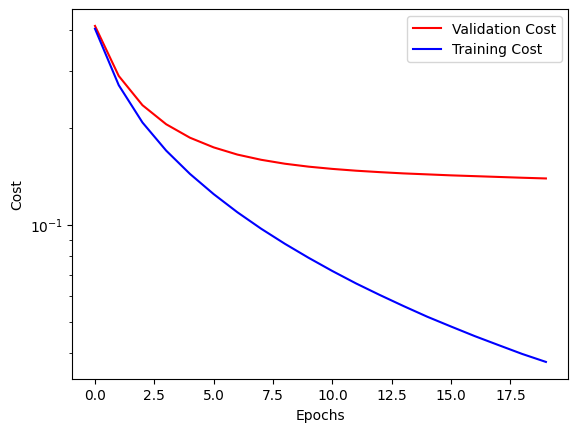

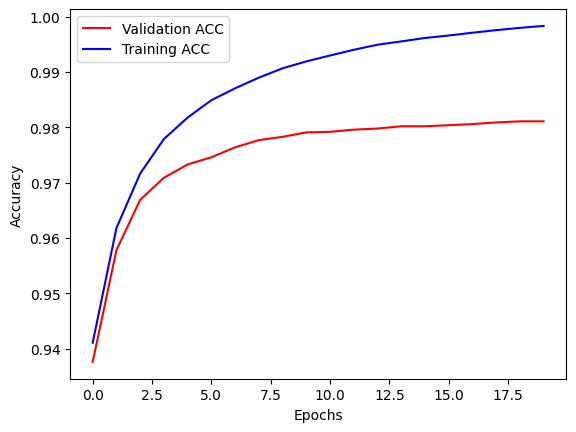

In [7]:
net = Network(layers=[784, 615, 10], cost_function='cross_entropy', activation_function='sigmoid')
train = (X_train, Y_train)
valid = (X_valid, Y_valid)
net.fit(train_set=train, batch_size=34, epochs=20, eta=0.4933969709233855, lmbda=1.1317790136149717, patience=10, valid_set=valid, show_history=True, visualize=True)

Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9308, cost_val: 0.4575, ACC_train: 0.9349166666666666, cost_train: 0.4473, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9427, cost_val: 0.3817, ACC_train: 0.9485166666666667, cost_train: 0.359, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9468, cost_val: 0.3508, ACC_train: 0.9553666666666667, cost_train: 0.3188, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9502, cost_val: 0.3346, ACC_train: 0.9597, cost_train: 0.2945, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9516, cost_val: 0.325, ACC_train: 0.9631166666666666, cost_train: 0.2774, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9524, cost_val: 0.3179, ACC_train: 0.9646333333333333, cost_train: 0.2638, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9527, cost_val: 0.3134, ACC_train: 0.9664166666666667, cost_train: 0.2529, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9537, cost_val: 0.3104, ACC_train: 0.9679, cost_train: 0.2439

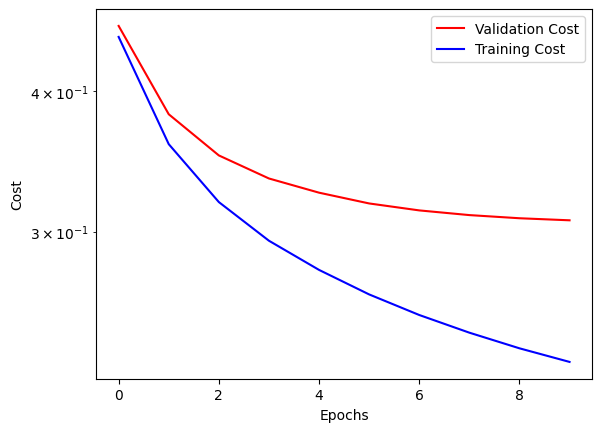

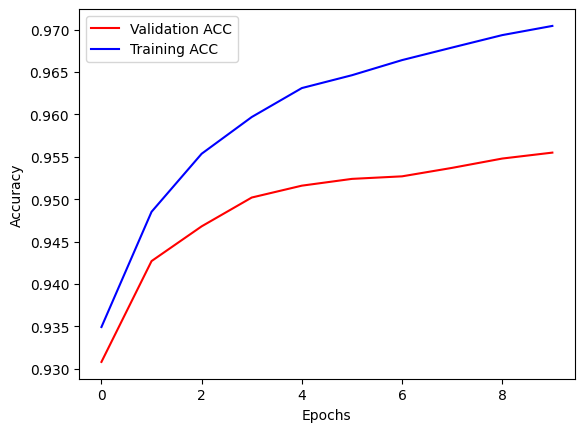

In [9]:
net = Network(layers=[784, 30, 10], cost_function='cross_entropy', activation_function='sigmoid')
train = (X_train, Y_train)
valid = (X_valid, Y_valid)
net.fit(train_set=train, batch_size=34, epochs=10, eta=0.4933969709233855, lmbda=1.1317790136149717, patience=10, valid_set=valid, show_history=True, visualize=True)

### Hyperparameter tuning

In [11]:
def objective(trial):
    n_neurons = trial.suggest_int('n_neurons', 1, 1000)
    eta = trial.suggest_float('eta', 1e-3, 0.5)
    lmbda = trial.suggest_float('lmbda', 1e-3, 10)
    batch_size = trial.suggest_int('batch_size', 10, 100)
    #cost_function = trial.suggest_categorical('cost_function', ['cross_entropy', 'quadratic'])
    #activation_function = trial.suggest_categorical('activation_function', ['sigmoid'])

    net = Network(layers=[784, n_neurons, 10], cost_function='cross_entropy', activation_function='sigmoid')
    train = (X_train, Y_train)
    valid = (X_valid, Y_valid)
    net.fit(train_set=train, batch_size=batch_size, epochs=15, eta=eta, lmbda=lmbda, patience=10, valid_set=valid, show_history=True, visualize=False)

    intermediate_acc = net.evaluate(X_valid, Y_valid)[1]
    #trial.report(intermediate_acc, 15)

    #if trial.should_prune():
        #raise optuna.TrialPruned()
    
    return intermediate_acc

#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
#study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-21 17:45:52,999] A new study created in memory with name: no-name-ae17c5e8-8d3c-46bd-882e-e2bd19f05dba


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9053, cost_val: 0.6204, ACC_train: 0.91248, cost_train: 0.6, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9262, cost_val: 0.4896, ACC_train: 0.93198, cost_train: 0.4639, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9385, cost_val: 0.4148, ACC_train: 0.944, cost_train: 0.3863, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9453, cost_val: 0.3657, ACC_train: 0.95204, cost_train: 0.3345, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9503, cost_val: 0.3312, ACC_train: 0.95784, cost_train: 0.2974, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9543, cost_val: 0.3057, ACC_train: 0.96268, cost_train: 0.2696, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9574, cost_val: 0.2863, ACC_train: 0.96628, cost_train: 0.2481, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9607, cost_val: 0.271, ACC_train: 0.96902, cost_train: 0.2309, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9624, cost_val:

[I 2024-07-21 18:01:57,084] Trial 0 finished with value: 0.9702 and parameters: {'n_neurons': 169, 'eta': 0.32824346604671195, 'lmbda': 8.478148783615286, 'batch_size': 51}. Best is trial 0 with value: 0.9702.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8966, cost_val: 0.7032, ACC_train: 0.9009, cost_train: 0.6866, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9178, cost_val: 0.5527, ACC_train: 0.92446, cost_train: 0.5281, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9334, cost_val: 0.4543, ACC_train: 0.9384, cost_train: 0.4267, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9434, cost_val: 0.3901, ACC_train: 0.94846, cost_train: 0.3599, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9477, cost_val: 0.3457, ACC_train: 0.95574, cost_train: 0.3127, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9526, cost_val: 0.3128, ACC_train: 0.96122, cost_train: 0.277, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9582, cost_val: 0.2876, ACC_train: 0.96572, cost_train: 0.249, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9619, cost_val: 0.2677, ACC_train: 0.96972, cost_train: 0.2261, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9635, cost_va

[I 2024-07-21 19:33:14,823] Trial 1 finished with value: 0.9725 and parameters: {'n_neurons': 865, 'eta': 0.42088514126204757, 'lmbda': 0.45863103007970274, 'batch_size': 78}. Best is trial 1 with value: 0.9725.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8705, cost_val: 0.8853, ACC_train: 0.87462, cost_train: 0.8792, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.8913, cost_val: 0.7495, ACC_train: 0.89694, cost_train: 0.7361, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9, cost_val: 0.6901, ACC_train: 0.90698, cost_train: 0.6722, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9064, cost_val: 0.6444, ACC_train: 0.91362, cost_train: 0.6234, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9136, cost_val: 0.6024, ACC_train: 0.9198, cost_train: 0.5792, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9195, cost_val: 0.5629, ACC_train: 0.92582, cost_train: 0.5382, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9242, cost_val: 0.527, ACC_train: 0.93066, cost_train: 0.5011, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9295, cost_val: 0.4952, ACC_train: 0.93534, cost_train: 0.4683, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9334, cost_val

[I 2024-07-21 20:52:29,228] Trial 2 finished with value: 0.9491 and parameters: {'n_neurons': 747, 'eta': 0.14145059453614986, 'lmbda': 5.506573600123844, 'batch_size': 71}. Best is trial 1 with value: 0.9725.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9042, cost_val: 0.649, ACC_train: 0.90958, cost_train: 0.6287, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9256, cost_val: 0.5035, ACC_train: 0.93142, cost_train: 0.4771, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9401, cost_val: 0.4135, ACC_train: 0.9449, cost_train: 0.3838, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.948, cost_val: 0.3548, ACC_train: 0.95394, cost_train: 0.3217, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9529, cost_val: 0.3135, ACC_train: 0.96118, cost_train: 0.277, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9583, cost_val: 0.2833, ACC_train: 0.96648, cost_train: 0.2433, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9623, cost_val: 0.2604, ACC_train: 0.97074, cost_train: 0.2171, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9649, cost_val: 0.2426, ACC_train: 0.97378, cost_train: 0.196, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.967, cost_val:

[I 2024-07-21 21:25:42,812] Trial 3 finished with value: 0.9744 and parameters: {'n_neurons': 319, 'eta': 0.16815865784415593, 'lmbda': 0.7635203865782237, 'batch_size': 26}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8788, cost_val: 0.8322, ACC_train: 0.88274, cost_train: 0.8237, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.8992, cost_val: 0.6953, ACC_train: 0.90434, cost_train: 0.6796, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9091, cost_val: 0.6246, ACC_train: 0.91452, cost_train: 0.6051, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9162, cost_val: 0.5693, ACC_train: 0.92274, cost_train: 0.5475, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9236, cost_val: 0.523, ACC_train: 0.92968, cost_train: 0.4995, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9289, cost_val: 0.4843, ACC_train: 0.9354, cost_train: 0.4594, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.934, cost_val: 0.4519, ACC_train: 0.94016, cost_train: 0.4257, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9389, cost_val: 0.4246, ACC_train: 0.94458, cost_train: 0.3972, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9424, cost_v

[I 2024-07-21 21:54:53,627] Trial 4 finished with value: 0.9567 and parameters: {'n_neurons': 307, 'eta': 0.21371023531186456, 'lmbda': 7.3489009249280395, 'batch_size': 91}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.919, cost_val: 0.5255, ACC_train: 0.92586, cost_train: 0.5031, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9378, cost_val: 0.4066, ACC_train: 0.94452, cost_train: 0.3786, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9473, cost_val: 0.3464, ACC_train: 0.95494, cost_train: 0.3151, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9529, cost_val: 0.3098, ACC_train: 0.96116, cost_train: 0.2753, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9575, cost_val: 0.2858, ACC_train: 0.9658, cost_train: 0.2481, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9607, cost_val: 0.2692, ACC_train: 0.96962, cost_train: 0.2284, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9627, cost_val: 0.2571, ACC_train: 0.97218, cost_train: 0.2135, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9644, cost_val: 0.2479, ACC_train: 0.97418, cost_train: 0.2019, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9656, cost_

[I 2024-07-21 21:59:01,430] Trial 5 finished with value: 0.9703 and parameters: {'n_neurons': 107, 'eta': 0.22521166824932695, 'lmbda': 8.702264237378355, 'batch_size': 22}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.86, cost_val: 0.9621, ACC_train: 0.86406, cost_train: 0.9591, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.8875, cost_val: 0.7932, ACC_train: 0.8911, cost_train: 0.7823, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.8957, cost_val: 0.7317, ACC_train: 0.90042, cost_train: 0.716, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9011, cost_val: 0.6925, ACC_train: 0.90712, cost_train: 0.6735, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9057, cost_val: 0.6598, ACC_train: 0.91192, cost_train: 0.6382, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9112, cost_val: 0.6289, ACC_train: 0.91686, cost_train: 0.6055, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9161, cost_val: 0.5988, ACC_train: 0.92154, cost_train: 0.574, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9196, cost_val: 0.5698, ACC_train: 0.92554, cost_train: 0.5439, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9224, cost_val

[I 2024-07-21 23:10:23,845] Trial 6 finished with value: 0.9406 and parameters: {'n_neurons': 714, 'eta': 0.13040953895675989, 'lmbda': 2.544395600863075, 'batch_size': 90}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8717, cost_val: 0.8833, ACC_train: 0.87372, cost_train: 0.8771, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.892, cost_val: 0.7499, ACC_train: 0.8965, cost_train: 0.7356, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9006, cost_val: 0.6894, ACC_train: 0.90684, cost_train: 0.6704, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9074, cost_val: 0.6427, ACC_train: 0.91372, cost_train: 0.6207, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9136, cost_val: 0.6001, ACC_train: 0.9199, cost_train: 0.5761, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9202, cost_val: 0.5601, ACC_train: 0.92608, cost_train: 0.5347, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9253, cost_val: 0.5235, ACC_train: 0.93142, cost_train: 0.4972, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9294, cost_val: 0.491, ACC_train: 0.9362, cost_train: 0.4638, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9345, cost_val

[I 2024-07-22 00:31:20,619] Trial 7 finished with value: 0.9497 and parameters: {'n_neurons': 785, 'eta': 0.18966537517416732, 'lmbda': 5.767729724168259, 'batch_size': 93}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8705, cost_val: 0.8951, ACC_train: 0.87268, cost_train: 0.89, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.8916, cost_val: 0.7566, ACC_train: 0.89574, cost_train: 0.7437, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.898, cost_val: 0.6998, ACC_train: 0.90524, cost_train: 0.6823, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9046, cost_val: 0.6587, ACC_train: 0.9112, cost_train: 0.6381, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9108, cost_val: 0.6216, ACC_train: 0.91696, cost_train: 0.5989, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9157, cost_val: 0.5862, ACC_train: 0.92246, cost_train: 0.5619, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9213, cost_val: 0.5527, ACC_train: 0.9274, cost_train: 0.5272, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9252, cost_val: 0.5219, ACC_train: 0.93166, cost_train: 0.4955, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9289, cost_val

[I 2024-07-22 01:37:51,459] Trial 8 finished with value: 0.9474 and parameters: {'n_neurons': 602, 'eta': 0.14407479830531864, 'lmbda': 7.020177739423882, 'batch_size': 78}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8929, cost_val: 0.7198, ACC_train: 0.89818, cost_train: 0.7049, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9125, cost_val: 0.5857, ACC_train: 0.91928, cost_train: 0.5631, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9264, cost_val: 0.4991, ACC_train: 0.93208, cost_train: 0.4732, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9367, cost_val: 0.4368, ACC_train: 0.9413, cost_train: 0.4091, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9441, cost_val: 0.3905, ACC_train: 0.94816, cost_train: 0.3612, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9489, cost_val: 0.3552, ACC_train: 0.95396, cost_train: 0.324, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9522, cost_val: 0.3274, ACC_train: 0.95894, cost_train: 0.2943, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9545, cost_val: 0.3052, ACC_train: 0.96252, cost_train: 0.27, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9582, cost_va

[I 2024-07-22 02:18:24,910] Trial 9 finished with value: 0.9682 and parameters: {'n_neurons': 300, 'eta': 0.33288734046140095, 'lmbda': 2.244413200028805, 'batch_size': 79}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8709, cost_val: 0.9034, ACC_train: 0.87508, cost_train: 0.8978, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.8934, cost_val: 0.7502, ACC_train: 0.89704, cost_train: 0.7372, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9007, cost_val: 0.6872, ACC_train: 0.90654, cost_train: 0.67, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9068, cost_val: 0.642, ACC_train: 0.91278, cost_train: 0.6219, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9133, cost_val: 0.6024, ACC_train: 0.91914, cost_train: 0.5802, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9192, cost_val: 0.5661, ACC_train: 0.92444, cost_train: 0.5423, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9228, cost_val: 0.533, ACC_train: 0.92914, cost_train: 0.508, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9272, cost_val: 0.5034, ACC_train: 0.93346, cost_train: 0.4773, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9311, cost_val

[I 2024-07-22 03:27:56,392] Trial 10 finished with value: 0.9477 and parameters: {'n_neurons': 427, 'eta': 0.017427621435294194, 'lmbda': 3.1205576808772952, 'batch_size': 10}. Best is trial 3 with value: 0.9744.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9194, cost_val: 0.5354, ACC_train: 0.92556, cost_train: 0.5135, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.943, cost_val: 0.3836, ACC_train: 0.94784, cost_train: 0.3559, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9538, cost_val: 0.3115, ACC_train: 0.96034, cost_train: 0.2775, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9609, cost_val: 0.269, ACC_train: 0.96784, cost_train: 0.2292, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9653, cost_val: 0.2408, ACC_train: 0.97356, cost_train: 0.1954, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9679, cost_val: 0.2209, ACC_train: 0.97746, cost_train: 0.1701, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.971, cost_val: 0.2061, ACC_train: 0.98078, cost_train: 0.1503, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9717, cost_val: 0.1949, ACC_train: 0.98316, cost_train: 0.1342, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9732, cost_v

[I 2024-07-22 05:21:38,303] Trial 11 finished with value: 0.9767 and parameters: {'n_neurons': 989, 'eta': 0.4586533053225932, 'lmbda': 0.22095998699264355, 'batch_size': 42}. Best is trial 11 with value: 0.9767.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9222, cost_val: 0.5193, ACC_train: 0.9281, cost_train: 0.4956, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9446, cost_val: 0.3693, ACC_train: 0.95078, cost_train: 0.3374, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9555, cost_val: 0.2994, ACC_train: 0.96296, cost_train: 0.2608, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9616, cost_val: 0.2585, ACC_train: 0.97068, cost_train: 0.214, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9667, cost_val: 0.2316, ACC_train: 0.9755, cost_train: 0.1816, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9714, cost_val: 0.2126, ACC_train: 0.97916, cost_train: 0.1576, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9727, cost_val: 0.1987, ACC_train: 0.98214, cost_train: 0.1389, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9738, cost_val: 0.1882, ACC_train: 0.9847, cost_train: 0.1237, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9746, cost_va

[I 2024-07-22 07:09:17,462] Trial 12 finished with value: 0.9781 and parameters: {'n_neurons': 948, 'eta': 0.47118875602095933, 'lmbda': 0.036355389409996164, 'batch_size': 40}. Best is trial 12 with value: 0.9781.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9181, cost_val: 0.5392, ACC_train: 0.92512, cost_train: 0.5165, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9403, cost_val: 0.3939, ACC_train: 0.94638, cost_train: 0.3651, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9508, cost_val: 0.3216, ACC_train: 0.95828, cost_train: 0.2879, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9568, cost_val: 0.2779, ACC_train: 0.96604, cost_train: 0.2395, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9629, cost_val: 0.2486, ACC_train: 0.97104, cost_train: 0.2057, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9674, cost_val: 0.2275, ACC_train: 0.97526, cost_train: 0.1804, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.97, cost_val: 0.2118, ACC_train: 0.97846, cost_train: 0.1606, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9722, cost_val: 0.1997, ACC_train: 0.98122, cost_train: 0.1445, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9735, cost_

[I 2024-07-22 09:01:15,937] Trial 13 finished with value: 0.9775 and parameters: {'n_neurons': 982, 'eta': 0.46953291587674684, 'lmbda': 0.597301776692657, 'batch_size': 47}. Best is trial 12 with value: 0.9781.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.915, cost_val: 0.5773, ACC_train: 0.91898, cost_train: 0.5565, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9383, cost_val: 0.4204, ACC_train: 0.94274, cost_train: 0.394, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9483, cost_val: 0.3412, ACC_train: 0.95554, cost_train: 0.3098, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9565, cost_val: 0.2943, ACC_train: 0.96402, cost_train: 0.2586, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9627, cost_val: 0.2638, ACC_train: 0.96966, cost_train: 0.2241, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.967, cost_val: 0.2426, ACC_train: 0.97348, cost_train: 0.1992, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9685, cost_val: 0.227, ACC_train: 0.97662, cost_train: 0.1802, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9704, cost_val: 0.2151, ACC_train: 0.97904, cost_train: 0.1652, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9721, cost_va

[I 2024-07-22 10:55:16,321] Trial 14 finished with value: 0.9764 and parameters: {'n_neurons': 972, 'eta': 0.3874549054808629, 'lmbda': 3.921712362265257, 'batch_size': 39}. Best is trial 12 with value: 0.9781.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9103, cost_val: 0.6009, ACC_train: 0.91516, cost_train: 0.5798, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9353, cost_val: 0.4407, ACC_train: 0.93948, cost_train: 0.4141, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9465, cost_val: 0.3565, ACC_train: 0.95264, cost_train: 0.3257, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9543, cost_val: 0.3055, ACC_train: 0.9616, cost_train: 0.2708, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9603, cost_val: 0.2716, ACC_train: 0.9678, cost_train: 0.233, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9643, cost_val: 0.2475, ACC_train: 0.97198, cost_train: 0.2051, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9678, cost_val: 0.2296, ACC_train: 0.97558, cost_train: 0.1835, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9702, cost_val: 0.2157, ACC_train: 0.9785, cost_train: 0.166, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9714, cost_val

[I 2024-07-22 12:01:08,907] Trial 15 finished with value: 0.9764 and parameters: {'n_neurons': 607, 'eta': 0.49812644577167836, 'lmbda': 1.574315053285468, 'batch_size': 59}. Best is trial 12 with value: 0.9781.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.8974, cost_val: 0.7025, ACC_train: 0.90386, cost_train: 0.6857, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.918, cost_val: 0.5645, ACC_train: 0.92452, cost_train: 0.5404, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9332, cost_val: 0.4689, ACC_train: 0.9379, cost_train: 0.4413, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9427, cost_val: 0.4046, ACC_train: 0.9468, cost_train: 0.374, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9477, cost_val: 0.3591, ACC_train: 0.95434, cost_train: 0.3258, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9532, cost_val: 0.3254, ACC_train: 0.96002, cost_train: 0.2898, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9582, cost_val: 0.2997, ACC_train: 0.96454, cost_train: 0.2618, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9627, cost_val: 0.2794, ACC_train: 0.9682, cost_train: 0.2394, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9639, cost_val

[I 2024-07-22 13:45:21,949] Trial 16 finished with value: 0.9708 and parameters: {'n_neurons': 895, 'eta': 0.3197685352038684, 'lmbda': 3.7924564700608174, 'batch_size': 58}. Best is trial 12 with value: 0.9781.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9296, cost_val: 0.4598, ACC_train: 0.93466, cost_train: 0.4374, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9491, cost_val: 0.3318, ACC_train: 0.95606, cost_train: 0.3005, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9594, cost_val: 0.2724, ACC_train: 0.96694, cost_train: 0.2337, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9644, cost_val: 0.2381, ACC_train: 0.97356, cost_train: 0.1927, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9687, cost_val: 0.2158, ACC_train: 0.97792, cost_train: 0.1644, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9724, cost_val: 0.2002, ACC_train: 0.98124, cost_train: 0.1434, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9736, cost_val: 0.1888, ACC_train: 0.98434, cost_train: 0.127, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9747, cost_val: 0.1803, ACC_train: 0.98668, cost_train: 0.1136, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9755, cost

[I 2024-07-22 15:01:59,741] Trial 17 finished with value: 0.9796 and parameters: {'n_neurons': 615, 'eta': 0.4933969709233855, 'lmbda': 1.1317790136149717, 'batch_size': 34}. Best is trial 17 with value: 0.9796.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.923, cost_val: 0.5148, ACC_train: 0.92816, cost_train: 0.4924, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9448, cost_val: 0.3627, ACC_train: 0.95128, cost_train: 0.3332, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9563, cost_val: 0.2945, ACC_train: 0.96348, cost_train: 0.2586, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9622, cost_val: 0.2558, ACC_train: 0.9706, cost_train: 0.214, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9667, cost_val: 0.2307, ACC_train: 0.97496, cost_train: 0.1835, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.97, cost_val: 0.213, ACC_train: 0.9787, cost_train: 0.1608, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9718, cost_val: 0.1999, ACC_train: 0.98214, cost_train: 0.1431, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.973, cost_val: 0.1897, ACC_train: 0.9847, cost_train: 0.1288, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9743, cost_val: 0.

[I 2024-07-22 16:10:13,816] Trial 18 finished with value: 0.978 and parameters: {'n_neurons': 523, 'eta': 0.3979511821005205, 'lmbda': 1.5738431107739, 'batch_size': 33}. Best is trial 17 with value: 0.9796.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9314, cost_val: 0.4585, ACC_train: 0.93614, cost_train: 0.4322, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9516, cost_val: 0.3197, ACC_train: 0.9592, cost_train: 0.2853, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.962, cost_val: 0.2625, ACC_train: 0.96942, cost_train: 0.2215, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9673, cost_val: 0.2319, ACC_train: 0.97508, cost_train: 0.1853, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9702, cost_val: 0.2131, ACC_train: 0.97888, cost_train: 0.1616, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9718, cost_val: 0.2003, ACC_train: 0.98198, cost_train: 0.1447, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9733, cost_val: 0.1911, ACC_train: 0.98438, cost_train: 0.1318, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9741, cost_val: 0.1842, ACC_train: 0.98618, cost_train: 0.1216, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9748, cost_

[I 2024-07-22 17:33:30,339] Trial 19 finished with value: 0.9775 and parameters: {'n_neurons': 603, 'eta': 0.27477872285331595, 'lmbda': 4.099763166689278, 'batch_size': 16}. Best is trial 17 with value: 0.9796.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9352, cost_val: 0.4352, ACC_train: 0.93998, cost_train: 0.4101, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9519, cost_val: 0.3208, ACC_train: 0.95926, cost_train: 0.2882, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9595, cost_val: 0.2748, ACC_train: 0.96752, cost_train: 0.2378, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9638, cost_val: 0.2501, ACC_train: 0.9724, cost_train: 0.2099, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.966, cost_val: 0.2347, ACC_train: 0.97554, cost_train: 0.1922, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9682, cost_val: 0.2244, ACC_train: 0.9777, cost_train: 0.18, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9699, cost_val: 0.217, ACC_train: 0.97928, cost_train: 0.1712, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9713, cost_val: 0.2115, ACC_train: 0.98048, cost_train: 0.1645, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9719, cost_val:

[I 2024-07-22 18:35:07,694] Trial 20 finished with value: 0.9747 and parameters: {'n_neurons': 443, 'eta': 0.4995715708657751, 'lmbda': 9.85657294830196, 'batch_size': 27}. Best is trial 17 with value: 0.9796.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9231, cost_val: 0.5115, ACC_train: 0.92836, cost_train: 0.4879, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9465, cost_val: 0.3666, ACC_train: 0.95044, cost_train: 0.3362, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9549, cost_val: 0.2975, ACC_train: 0.96252, cost_train: 0.2609, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9624, cost_val: 0.2585, ACC_train: 0.9695, cost_train: 0.2158, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9655, cost_val: 0.2333, ACC_train: 0.9748, cost_train: 0.185, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9685, cost_val: 0.2155, ACC_train: 0.97862, cost_train: 0.1622, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9709, cost_val: 0.2021, ACC_train: 0.98186, cost_train: 0.1443, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9731, cost_val: 0.1918, ACC_train: 0.98438, cost_train: 0.1298, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9743, cost_v

[I 2024-07-22 19:48:46,481] Trial 21 finished with value: 0.9781 and parameters: {'n_neurons': 505, 'eta': 0.40466710619835955, 'lmbda': 1.5466644893952288, 'batch_size': 33}. Best is trial 17 with value: 0.9796.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9239, cost_val: 0.5093, ACC_train: 0.92906, cost_train: 0.4852, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9456, cost_val: 0.3646, ACC_train: 0.95064, cost_train: 0.3336, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9551, cost_val: 0.2988, ACC_train: 0.96318, cost_train: 0.2608, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9623, cost_val: 0.2603, ACC_train: 0.97046, cost_train: 0.216, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9664, cost_val: 0.2346, ACC_train: 0.97506, cost_train: 0.1849, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9699, cost_val: 0.2162, ACC_train: 0.97868, cost_train: 0.1617, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9717, cost_val: 0.2024, ACC_train: 0.9817, cost_train: 0.1436, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9732, cost_val: 0.1917, ACC_train: 0.984, cost_train: 0.1289, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9739, cost_va

[I 2024-07-22 21:00:52,270] Trial 22 finished with value: 0.9783 and parameters: {'n_neurons': 514, 'eta': 0.430298141323347, 'lmbda': 1.5259147292543003, 'batch_size': 36}. Best is trial 17 with value: 0.9796.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9194, cost_val: 0.5247, ACC_train: 0.92654, cost_train: 0.5023, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9443, cost_val: 0.3718, ACC_train: 0.94968, cost_train: 0.342, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9543, cost_val: 0.301, ACC_train: 0.96256, cost_train: 0.2647, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9625, cost_val: 0.2599, ACC_train: 0.97022, cost_train: 0.2177, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9665, cost_val: 0.2336, ACC_train: 0.97484, cost_train: 0.1854, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.97, cost_val: 0.2153, ACC_train: 0.9789, cost_train: 0.1614, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9715, cost_val: 0.202, ACC_train: 0.98202, cost_train: 0.1426, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9722, cost_val: 0.1919, ACC_train: 0.98464, cost_train: 0.1273, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9733, cost_val:

[I 2024-07-22 22:32:59,947] Trial 23 finished with value: 0.9779 and parameters: {'n_neurons': 674, 'eta': 0.4426557594975415, 'lmbda': 0.04399949874687259, 'batch_size': 39}. Best is trial 17 with value: 0.9796.


Tracking progress on the validation set:
acc
cost
epoch: 0, ACC_val: 0.9068, cost_val: 0.6381, ACC_train: 0.91196, cost_train: 0.6175, no_progress_count: 0
acc
cost
epoch: 1, ACC_val: 0.9308, cost_val: 0.4788, ACC_train: 0.93448, cost_train: 0.4527, no_progress_count: 0
acc
cost
epoch: 2, ACC_val: 0.9436, cost_val: 0.3877, ACC_train: 0.94814, cost_train: 0.3578, no_progress_count: 0
acc
cost
epoch: 3, ACC_val: 0.9507, cost_val: 0.3321, ACC_train: 0.95722, cost_train: 0.2981, no_progress_count: 0
acc
cost
epoch: 4, ACC_val: 0.9561, cost_val: 0.2943, ACC_train: 0.96392, cost_train: 0.2566, no_progress_count: 0
acc
cost
epoch: 5, ACC_val: 0.9608, cost_val: 0.2669, ACC_train: 0.96922, cost_train: 0.2258, no_progress_count: 0
acc
cost
epoch: 6, ACC_val: 0.9643, cost_val: 0.2461, ACC_train: 0.97334, cost_train: 0.2018, no_progress_count: 0
acc
cost
epoch: 7, ACC_val: 0.9669, cost_val: 0.2298, ACC_train: 0.97622, cost_train: 0.1825, no_progress_count: 0
acc
cost
epoch: 8, ACC_val: 0.9689, cos

[I 2024-07-23 00:21:27,991] Trial 24 finished with value: 0.9757 and parameters: {'n_neurons': 802, 'eta': 0.3573140255191926, 'lmbda': 1.2781626822003391, 'batch_size': 48}. Best is trial 17 with value: 0.9796.


Number of finished trials:  25
Best trial:
  Value:  0.9796
  Params: 
    n_neurons: 615
    eta: 0.4933969709233855
    lmbda: 1.1317790136149717
    batch_size: 34
